<a href="https://colab.research.google.com/github/OJB-Quantum/MuMax3-How-To/blob/main/Python%20Code_MuMax3%20Data%20Plots/MRAM_Bit_Switch_Example_in_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

In [ ]:
# --------------------------------------------------------------
# Install the helper libraries
# --------------------------------------------------------------
!pip -q install pyovf imageio matplotlib pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.1 MB/s eta 0:00:00


In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""MRAM bit‑switch example.

The script

1. writes a MuMax³ input file,
2. runs the MuMax³ simulation,
3. converts the OVF snapshots to plain RGB heat‑maps,
4. creates PNGs that **overlay a quiver plot** (arrow_size = 1) on the
   heat‑map and adds three colour‑bars (mx→red, my→green, mz→blue),
5. animates the overlay frames inline,
6. saves the animation as a downloadable GIF.

All figures are rendered at **200 dpi** (set globally via
``plt.rcParams["figure.dpi"]``) and the animation reads each frame from
disk on‑the‑fly, keeping the memory footprint small – important for an
Nvidia L4 GPU in Colab.
"""

# --------------------------------------------------------------
# Imports (standard‑library first, then third‑party)
# --------------------------------------------------------------
import gc
import glob
import os
import subprocess
from typing import List

import imageio.v2 as imageio
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pyovf as ovf
from IPython.display import HTML, display
from tqdm import tqdm

# --------------------------------------------------------------
# Global Matplotlib configuration – 200 dpi for *all* figures
# --------------------------------------------------------------
plt.rcParams["figure.dpi"] = 200

# --------------------------------------------------------------
# Geometry constants (must match the MuMax³ script)
# --------------------------------------------------------------
GRID_X = 64            # cells along x
GRID_Y = 32            # cells along y
GRID_Z = 1             # single layer (no thickness discretization)

SIZE_X = 160e-9        # total length  (m)
SIZE_Y = 80e-9         # total width   (m)
SIZE_Z = 5e-9          # total thickness (m)

CELL_X = SIZE_X / GRID_X
CELL_Y = SIZE_Y / GRID_Y

OUT_DIR = "mram_bit_switch.out"
RGB_DIR = "rgb_frames"
OVERLAY_DIR = "overlay_frames"
TABLE_FILE = "table.txt"
TMAX_NS = 0.5          # final simulation time (ns)

# --------------------------------------------------------------
# Pre‑computed mesh (cell centres) – reused for every frame
# --------------------------------------------------------------
_X = (np.arange(GRID_X) + 0.5) * CELL_X - SIZE_X / 2.0
_Y = (np.arange(GRID_Y) + 0.5) * CELL_Y - SIZE_Y / 2.0
X_MESH, Y_MESH = np.meshgrid(_X * 1e9, _Y * 1e9)   # (nm)

# Extent for imshow – y‑order reversed so the image is upright.
_EXTENT = [
    _X.min() * 1e9,
    _X.max() * 1e9,
    _Y.max() * 1e9,   # top
    _Y.min() * 1e9,   # bottom
]

# --------------------------------------------------------------
# Small helper: run a shell command (stdout/stderr are discarded)
# --------------------------------------------------------------
def run_shell(command: str) -> None:
    """Execute *command* in a subshell (output is discarded)."""
    subprocess.run(
        command,
        shell=True,
        check=False,
        stdout=subprocess.PIPE,
        stderr=subprocess.STDOUT,
    )


# --------------------------------------------------------------
# 1️⃣  Write the MuMax³ input script
# --------------------------------------------------------------
def write_mumax_script(fname: str = "mram_bit_switch.mx3") -> None:
    """Write the MuMax³ script that defines the elliptical MRAM bit."""
    script = r"""// -------------------------------------------------------------------
//  MuMax³ script: elliptical MRAM bit switch (Slonczewski STT)
//  – 64 × 32 × 1 cells, 160 nm × 80 nm × 5 nm
// -------------------------------------------------------------------

// --- mesh -----------------------------------------------------------
Nx := 64
Ny := 32
Nz := 1
sizeX := 160e-9
sizeY := 80e-9
sizeZ := 5e-9
setgridsize(Nx, Ny, Nz)
setcellsize(sizeX/Nx, sizeY/Ny, sizeZ/Nz)

// --- geometry --------------------------------------------------------
mygeom := ellipse(sizeX, sizeY)   // 2‑D ellipse centred in the box
setgeom(mygeom)

// --- material ---------------------------------------------------------
Msat = 800e3          // A/m
Aex  = 13e-12         // J/m
alpha = 0.01

// --- initial state ----------------------------------------------------
m = uniform(1, 0, 0)   // magnetization along +x
relax()                // minimise the energy first

// --- Slonczewski spin‑transfer torque ---------------------------------
DisableZhangLiTorque = true          // use only the Slonczewski term
Pol = 0.5669
Lambda = 2
EpsilonPrime = 1

// current density: -4 mA spread over the elliptical area
area := pi * sizeX * sizeY / 4        // πab/4
J = vector(0, 0, -4e-3/area)          // A·m⁻²

// fixed layer (20° from the x‑axis, on top of the free layer)
theta := 20 * pi/180
FixedLayer = vector(cos(theta), sin(theta), 0)
FixedLayerPosition = FIXEDLAYER_TOP

// --- table of spatial averages (⟨mx⟩, ⟨my⟩, ⟨mz⟩) ----------------------
mx := m.Comp(0)
my := m.Comp(1)
mz := m.Comp(2)
tableadd(mx)
tableadd(my)
tableadd(mz)

// --- time stepping ----------------------------------------------------
tmax   := 0.5e-9                // final time
npts   := 151                   // #output points (incl. t = 0)
stepSize := tmax/(npts-1)      // constant step size
nsteps := npts-1

for i := 0; i <= nsteps; i++ {
    // Save a snapshot before the first step and after each step.
    saveas(m, sprintf("frame_%04d.ovf", i))

    // Append a line to the data table (time + mx, my, mz)
    tablesave()

    // After the last snapshot we stop; otherwise advance the solver.
    if i < nsteps { run(stepSize) }
}
"""
    with open(fname, "w", encoding="utf-8") as f:
        f.write(script)


# --------------------------------------------------------------
# 2️⃣  OVF I/O helpers
# --------------------------------------------------------------
def read_ovf_vector(fname: str) -> np.ndarray:
    """Read *fname* and return a (ny, nx, 3) magnetization array."""
    _, _, data = ovf.read(fname)            # shape (nz, ny, nx, 3)
    return np.squeeze(data, axis=0)          # (ny, nx, 3)


def vector_to_rgb(vec: np.ndarray) -> np.ndarray:
    """Map a normalised magnetization vector to an 8‑bit RGB image."""
    return ((vec + 1.0) * 127.5).astype(np.uint8)


# --------------------------------------------------------------
# 3️⃣  Create a PNG that overlays a quiver plot on the RGB heat‑map
# --------------------------------------------------------------
def create_overlay_image(
    ovf_path: str,
    out_path: str,
    arrow_size: float = 1.0,
) -> None:
    """Write a PNG that shows the heat‑map **plus** a vector‑field overlay.

    The PNG does **not** contain colour‑bars – they are added later when the
    animation is built.  This keeps the PNG small and guarantees that the
    colour‑bars never obscure the data.
    """
    # ----------------------------------------------------------
    # Load the magnetization field
    # ----------------------------------------------------------
    vec = read_ovf_vector(ovf_path)
    mx, my, mz = vec[..., 0], vec[..., 1], vec[..., 2]

    # ----------------------------------------------------------
    # Background RGB image
    # ----------------------------------------------------------
    rgb = vector_to_rgb(vec)

    # ----------------------------------------------------------
    # Plot background, geometry and quiver
    # ----------------------------------------------------------
    fig, ax = plt.subplots(figsize=(8.0, 4.0))
    # Reserve the full width for the image – colour‑bars will be drawn later.
    fig.subplots_adjust(left=0.08, right=0.96)

    ax.imshow(rgb, extent=_EXTENT)

    # Elliptical geometry outline
    ellipse = patches.Ellipse(
        (0, 0),
        width=SIZE_X * 1e9,
        height=SIZE_Y * 1e9,
        edgecolor="k",
        facecolor="none",
        lw=1.2,
    )
    ax.add_patch(ellipse)

    # Quiver (in‑plane vectors) coloured by mz
    norm = mcolors.Normalize(vmin=-1.0, vmax=1.0)
    ax.quiver(
        X_MESH,
        Y_MESH,
        mx * arrow_size,
        my * arrow_size,
        mz,
        cmap="bwr",
        norm=norm,
        scale=1,
        scale_units="xy",
        width=0.003,
        headwidth=3,
        headlength=4,
        pivot="mid",
        clim=(-1, 1),
    )

    # ----------------------------------------------------------
    # Final cosmetics
    # ----------------------------------------------------------
    ax.set_aspect("equal")
    ax.set_xlabel("x (nm)")
    ax.set_ylabel("y (nm)")
    ax.set_title(f"Overlay – {os.path.basename(ovf_path)}")
    plt.tight_layout()
    plt.savefig(out_path)          # uses the global 200 dpi
    plt.close(fig)

    # ----------------------------------------------------------
    # Free memory early (important on a modest GPU)
    # ----------------------------------------------------------
    del vec, rgb
    gc.collect()


# --------------------------------------------------------------
# 4️⃣  Optional: plain RGB heat‑maps (no quiver)
# --------------------------------------------------------------
def convert_ovf_to_rgb_pngs(ovf_files: List[str], out_dir: str) -> None:
    """Create a simple RGB PNG for every OVF file (no overlay)."""
    os.makedirs(out_dir, exist_ok=True)
    for path in tqdm(ovf_files, desc="OVF → RGB PNG"):
        rgb = vector_to_rgb(read_ovf_vector(path))
        png_name = os.path.splitext(os.path.basename(path))[0] + ".png"
        out_path = os.path.join(out_dir, png_name)
        imageio.imwrite(out_path, rgb)


# --------------------------------------------------------------
# 5️⃣  Generate all overlay PNGs
# --------------------------------------------------------------
def generate_overlay_frames(
    ovf_files: List[str],
    out_dir: str,
    arrow_size: float = 1.0,
) -> None:
    """Create coloured‑quiver PNGs for every snapshot."""
    os.makedirs(out_dir, exist_ok=True)
    for path in tqdm(ovf_files, desc="OVF → overlay PNG"):
        png_name = os.path.splitext(os.path.basename(path))[0] + ".png"
        out_path = os.path.join(out_dir, png_name)
        create_overlay_image(path, out_path, arrow_size=arrow_size)


# --------------------------------------------------------------
# 6️⃣  Plot spatial averages ⟨mx⟩, ⟨my⟩, ⟨mz⟩ versus time
# --------------------------------------------------------------
def plot_spatial_averages(table_path: str) -> None:
    """Read the MuMax³ table and plot the three spatial averages."""
    df = pd.read_csv(
        table_path,
        comment="#",
        sep=r"\s+",
    )
    if df.shape[1] < 4:
        raise RuntimeError(
            "Unexpected table format – fewer than 4 columns."
        )
    df = df.iloc[:, :4].copy()
    df.columns = ["time", "mx", "my", "mz"]
    df["time_ns"] = df["time"] * 1e9

    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(df["time_ns"], df["mx"], label="⟨mx⟩")
    ax.plot(df["time_ns"], df["my"], label="⟨my⟩")
    ax.plot(df["time_ns"], df["mz"], label="⟨mz⟩")
    ax.set_xlabel("time $t$ (ns)")
    ax.set_ylabel("spatial average ⟨m⟩")
    ax.set_title("Elliptical MRAM bit switch – ⟨m⟩(t)")
    ax.set_xlim(0, df["time_ns"].max())
    ax.set_ylim(-1.05, 1.05)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------
# 7️⃣  Animate the overlay PNG frames (inline, memory‑friendly)
# --------------------------------------------------------------
def animate_overlay_frames(png_dir: str, fps: int = 15) -> animation.FuncAnimation:
    """Return a FuncAnimation that steps through the overlay PNG frames.

    The colour‑bars (mx, my, mz) are added **once** to the figure,
    positioned on the far right so they never hide the data.
    Frames are loaded from disk on‑the‑fly; only one frame lives in RAM.
    """
    png_paths = sorted(
        glob.glob(os.path.join(png_dir, "frame_*.png"))
    )
    n_frames = len(png_paths)
    times = np.linspace(0.0, TMAX_NS, n_frames)

    # ----------------------------------------------------------
    # Figure layout: image on the left, colour‑bars on the right
    # ----------------------------------------------------------
    fig = plt.figure(figsize=(8.0, 4.0))
    gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.05)

    ax_img = fig.add_subplot(gs[0])
    ax_img.axis("off")                     # hide axes, keep only the image

    # Load the first frame to initialise the AxesImage object.
    first_img = imageio.imread(png_paths[0])
    im = ax_img.imshow(first_img)

    # ----------------------------------------------------------
    # Static colour‑bars (mx → red, my → green, mz → bwr)
    # ----------------------------------------------------------
    norm = mcolors.Normalize(vmin=-1.0, vmax=1.0)

    cmap_red = mcolors.LinearSegmentedColormap.from_list(
        "red_cmap", [(0, "black"), (1, "red")]
    )
    sm_mx = cm.ScalarMappable(cmap=cmap_red, norm=norm)
    cax_mx = fig.add_axes([0.73, 0.55, 0.02, 0.30])
    fig.colorbar(sm_mx, cax=cax_mx).set_label("mx")

    cmap_green = mcolors.LinearSegmentedColormap.from_list(
        "green_cmap", [(0, "black"), (1, "green")]
    )
    sm_my = cm.ScalarMappable(cmap=cmap_green, norm=norm)
    cax_my = fig.add_axes([0.73, 0.15, 0.02, 0.30])
    fig.colorbar(sm_my, cax=cax_my).set_label("my")

    sm_mz = cm.ScalarMappable(cmap=plt.cm.bwr, norm=norm)
    cax_mz = fig.add_axes([0.73, 0.85, 0.02, 0.07])
    fig.colorbar(sm_mz, cax=cax_mz).set_label("mz (arrow colour)")

    # ----------------------------------------------------------
    # Update routine – load the i‑th frame from disk
    # ----------------------------------------------------------
    def _update(i: int):
        """Replace the displayed image with frame *i*."""
        img = imageio.imread(png_paths[i])
        im.set_data(img)
        ax_img.set_title(f"$t = {times[i]:.3f}\\,$ ns", fontsize=10)
        return [im]

    anim = animation.FuncAnimation(
        fig,
        _update,
        frames=n_frames,
        interval=1000 / fps,
        blit=True,
    )
    return anim


# --------------------------------------------------------------
# 8️⃣  Save a GIF (downloadable)
# --------------------------------------------------------------
def save_animation_as_gif(
    anim: animation.FuncAnimation,
    path: str,
    fps: int = 15,
    dpi: int = 200,
) -> None:
    """Write *anim* to *path* as an animated GIF."""
    anim.save(path, writer="ffmpeg", fps=fps, dpi=dpi)
    print(f"Saved GIF → {path}")


# --------------------------------------------------------------
# 9️⃣  Full workflow (GPU check → MuMax³ → post‑processing → visualization)
# --------------------------------------------------------------
def main() -> None:
    """Run the complete MRAM‑bit‑switch example."""
    # ----------------------------------------------------------
    # GPU check (optional)
    # ----------------------------------------------------------
    print("Checking GPU availability …")
    run_shell(
        'nvidia-smi --query-gpu="name,driver_version,compute_cap" '
        '--format=csv,noheader'
    )

    # ----------------------------------------------------------
    # Install MuMax³ (run once per notebook)
    # ----------------------------------------------------------
    print("Downloading and installing MuMax³ …")
    run_shell(
        "wget -q https://mumax.ugent.be/mumax3-binaries/"
        "mumax3.10_linux_cuda10.1.tar.gz"
    )
    run_shell("tar -xvf mumax3.10_linux_cuda10.1.tar.gz > /dev/null")
    run_shell("rm mumax3.10_linux_cuda10.1.tar.gz")
    run_shell(
        "rm -rf mumax3.10 && mv mumax3.10_linux_cuda10.1 mumax3.10"
    )
    run_shell("chmod +x /content/mumax3.10/mumax3")
    run_shell("chmod +x /content/mumax3.10/mumax3-convert")

    # Extend environment for the current Python process
    os.environ["PATH"] += os.pathsep + "/content/mumax3.10"
    os.environ["LD_LIBRARY_PATH"] = (
        os.getenv("LD_LIBRARY_PATH", "")
        + os.pathsep
        + "/content/mumax3.10"
    )

    # ----------------------------------------------------------
    # (Re‑)install required Python packages (just in case)
    # ----------------------------------------------------------
    print("Installing helper libraries …")
    run_shell("pip -q install pyovf imageio matplotlib pandas tqdm")

    # ----------------------------------------------------------
    # Write and run the MuMax³ script
    # ----------------------------------------------------------
    write_mumax_script()
    print("Running MuMax³ simulation …")
    run_shell("rm -rf mram_bit_switch.out")
    run_shell("mumax3 mram_bit_switch.mx3")

    # ----------------------------------------------------------
    # Gather OVF snapshots
    # ----------------------------------------------------------
    ovf_files = sorted(
        glob.glob(os.path.join(OUT_DIR, "frame_*.ovf"))
    )
    print(f"Found {len(ovf_files)} OVF snapshots.")

    # ----------------------------------------------------------
    # (Optional) plain RGB heat‑maps – no overlay
    # ----------------------------------------------------------
    convert_ovf_to_rgb_pngs(ovf_files, RGB_DIR)

    # ----------------------------------------------------------
    # Create overlay PNGs (heat‑map + quiver, colour‑bars added later)
    # ----------------------------------------------------------
    generate_overlay_frames(ovf_files, OVERLAY_DIR, arrow_size=1.0)

    # ----------------------------------------------------------
    # Plot the spatial averages
    # ----------------------------------------------------------
    plot_spatial_averages(os.path.join(OUT_DIR, TABLE_FILE))

    # ----------------------------------------------------------
    # Build and display the animation inline
    # ----------------------------------------------------------
    overlay_anim = animate_overlay_frames(OVERLAY_DIR, fps=15)
    display(HTML(overlay_anim.to_jshtml()))

    # ----------------------------------------------------------
    # Export the animation to a downloadable GIF
    # ----------------------------------------------------------
    gif_path = "MRAM_bit_switch_overlay.gif"
    save_animation_as_gif(overlay_anim, gif_path, fps=15, dpi=200)

    # ----------------------------------------------------------
    # Offer the file for download (Colab only)
    # ----------------------------------------------------------
    try:
        from google.colab import files
        files.download(gif_path)
    except Exception:
        print(
            f"GIF saved as {gif_path}. Download manually if you are not on "
            "Colab."
        )


# --------------------------------------------------------------
# Entry point
# --------------------------------------------------------------
if __name__ == "__main__":
    main()


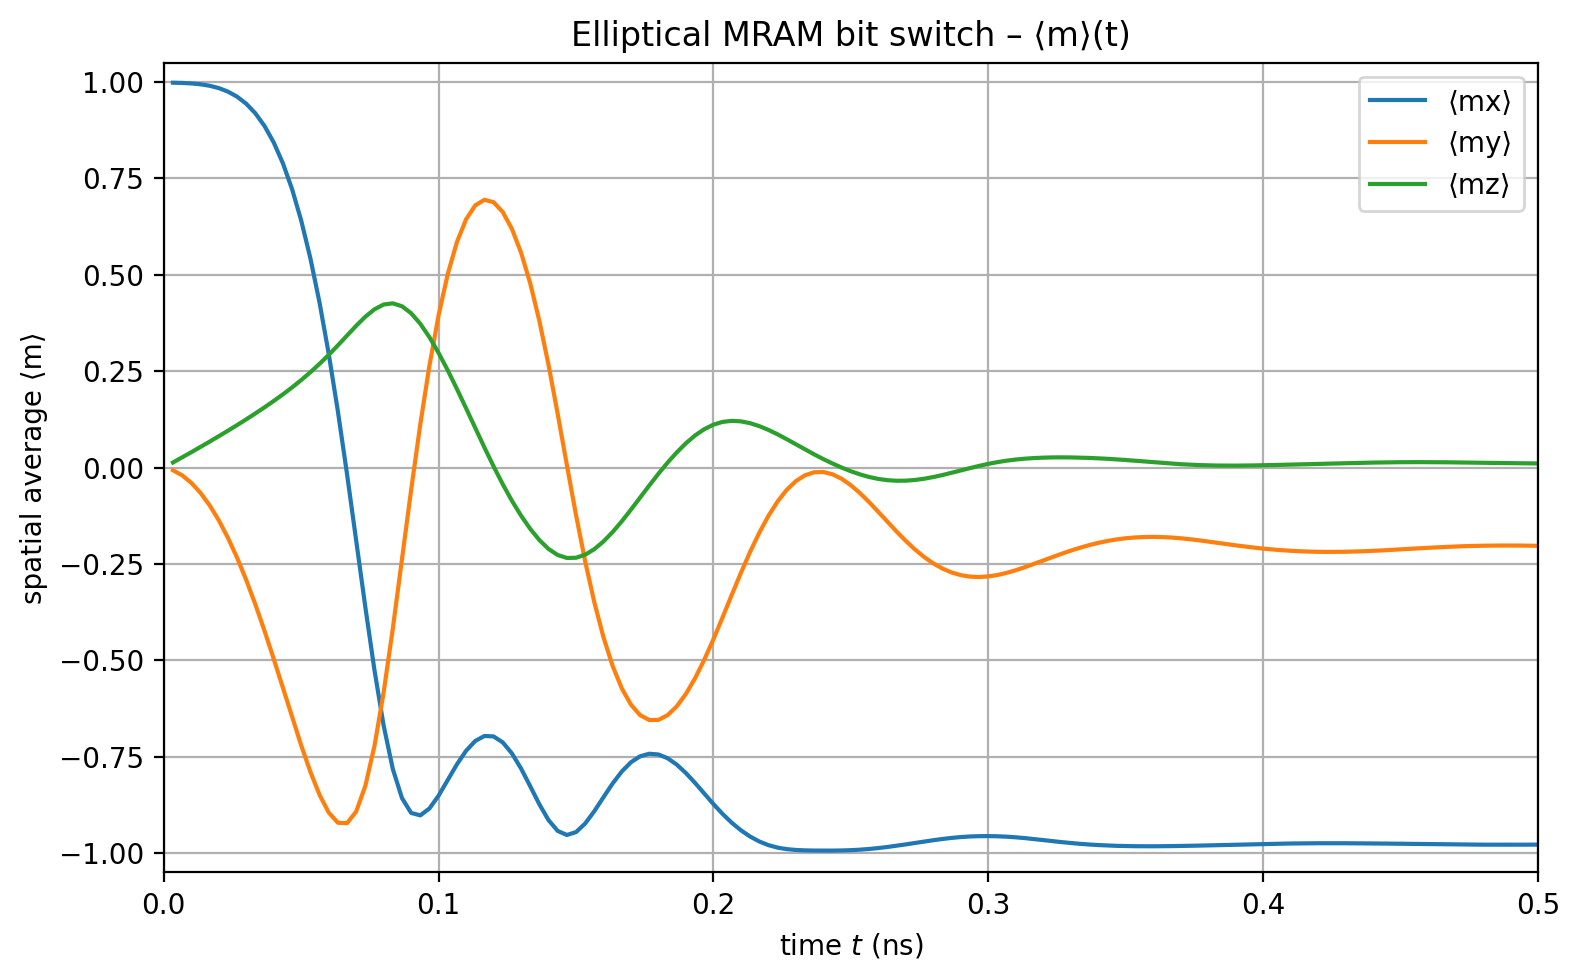

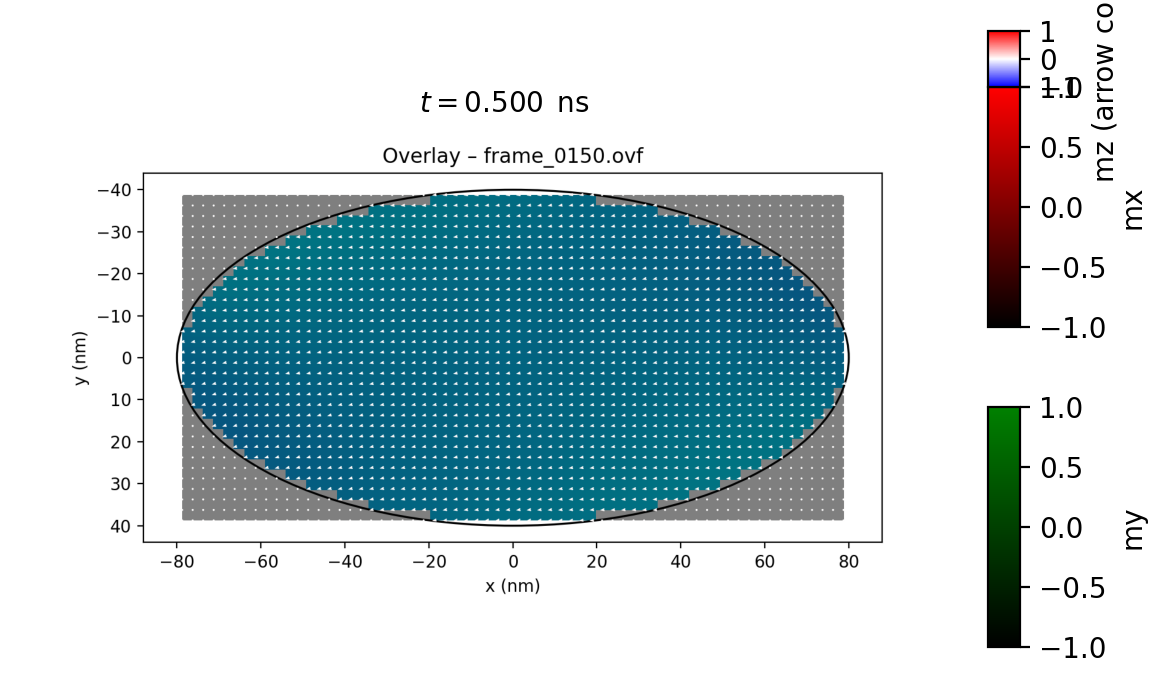

In [ ]:
# ----------------------------------------------------------------------
#   Animate the magnetization – rainbow gradient legend
# ----------------------------------------------------------------------
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import imageio.v2 as imageio          # v2 API → no deprecation warning
import numpy as np
import glob, os
from IPython.display import HTML

# ------------------------------------------------------------------
# Load the PNG frames that were created from the OVF snapshots
# ------------------------------------------------------------------
png_files = sorted(
    glob.glob(os.path.join(RGB_DIR, "frame_*.png")))
rgb_frames = [imageio.imread(p) for p in png_files]

# ------------------------------------------------------------------
# Build a time vector that matches the number of frames.
# The simulation ran up to tmax = 0.5 ns, so we linearly interpolate.
# ------------------------------------------------------------------
tmax_ns = 0.5                                 # final time in ns
times_ns = np.linspace(0.0, tmax_ns, len(rgb_frames))

# ------------------------------------------------------------------
# Physical extents – the same as used for the MuMax³ mesh
# ------------------------------------------------------------------
length, width = 160e-9, 80e-9
nx, ny = 64, 32
cx, cy = length / nx, width / ny
extent = np.array([-0.5 * cx,
                  length - 0.5 * cx,
                  -0.5 * cy,
                  width - 0.5 * cy]) * 1e9   # convert to nm

# ------------------------------------------------------------------
# Create the figure & plot the first frame
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.4, 4))
im = ax.imshow(rgb_frames[0],
               origin='lower',
               extent=extent)
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')

# ------------------------------------------------------------------
# ----  Add a *rainbow* colour bar  ----
# ------------------------------------------------------------------
# The RGB image was built by mapping each component from -1…+1 to
#   0…255   (R←mx, G←my, B←mz).  Here we add a generic colour bar that
#   spans the same numeric range (‑1 → +1) using the HSV (rainbow) colormap.
cmap = plt.cm.hsv
norm = plt.Normalize(vmin=-1, vmax=1)
# A ScalarMappable is needed only for the colour bar – it does not affect
# the image itself.
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])            # required for some Matplotlib versions
cbar = fig.colorbar(sm,
                    ax=ax,
                    fraction=0.046,
                    pad=0.04)
cbar.set_label('Rainbow colour (≈ combined mx, my, mz)', fontsize=9)
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['‑1', '0', '+1'])

# ------------------------------------------------------------------
# Animation update routine
# ------------------------------------------------------------------
def update(frame_idx):
    """Update the displayed image and title for frame *frame_idx*."""
    im.set_data(rgb_frames[frame_idx])
    ax.set_title(f"$t = {times_ns[frame_idx]:.3f}\\,$ ns")
    return [im]

# ------------------------------------------------------------------
# Build the animation (15 fps) and display it inline
# ------------------------------------------------------------------
fps = 15
anim = animation.FuncAnimation(fig,
                               update,
                               frames=len(rgb_frames),
                               interval=1000 / fps,
                               blit=True)

HTML(anim.to_jshtml())


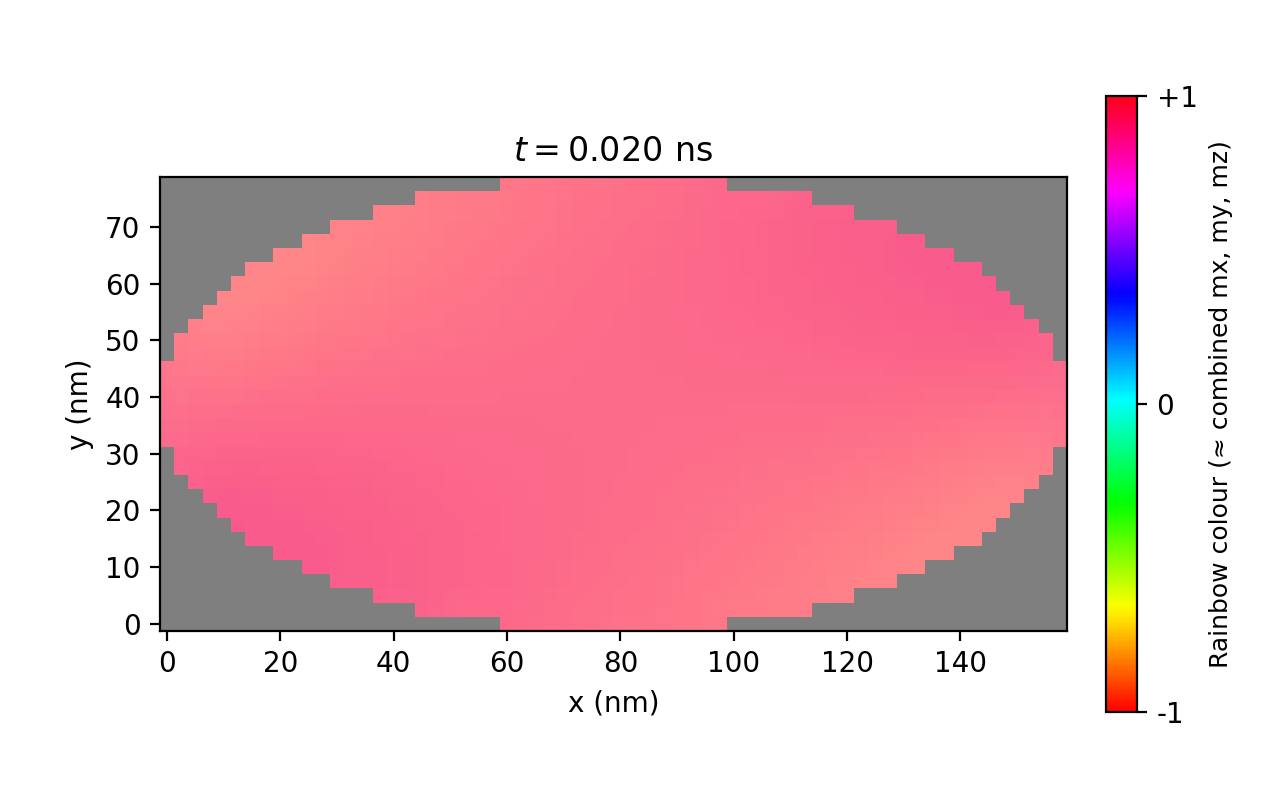

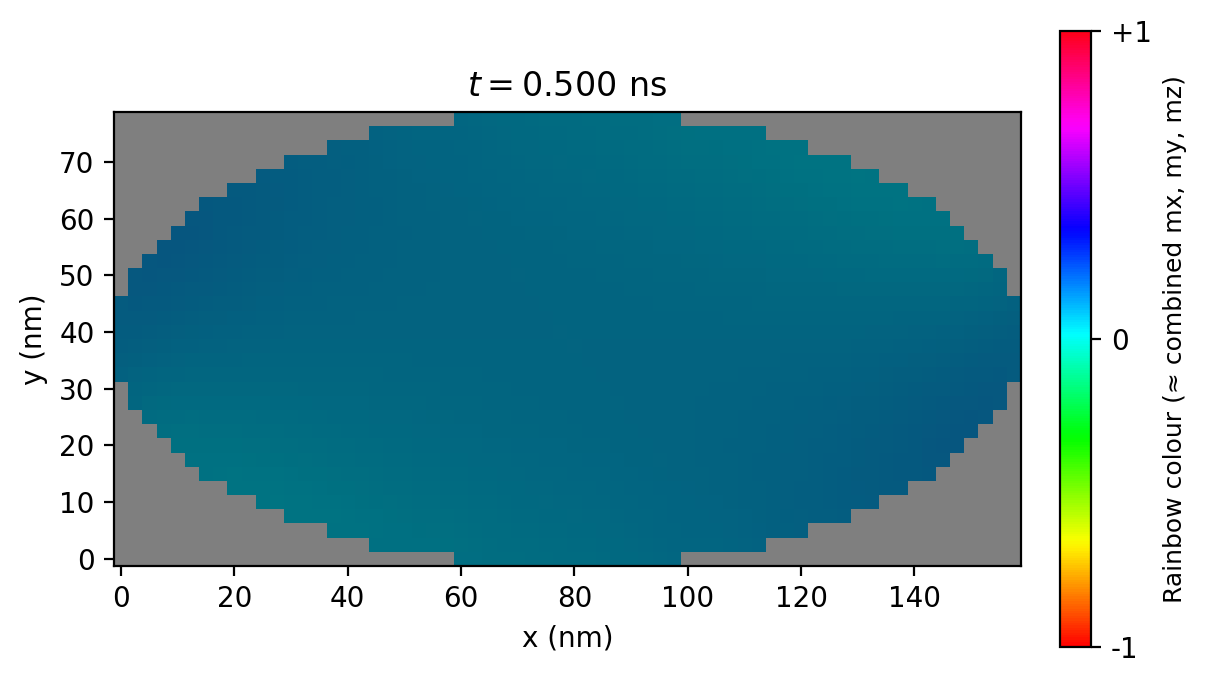